## Backtest framework

### Backtesting transformation, data storage, data analysis

This section contains the `portfolio` type that can amend its own state by adding assets to the portfolio, and removing assets form the portfolio. The portfolio is time independent, therefore it simulates a real time time independent state of a normal portfolio. Time series signal generation will be on another file

In [4]:
import pandas as pd
from sqlalchemy import create_engine, Table, select, MetaData
from sqlalchemy.orm import sessionmaker, declarative_base
from datetime import date, timedelta

class InitialisePortfolio:
    def __init__(self, portfolio_name, cash, minimum_cash):
        self.portfolio_name = portfolio_name
        self.assets = {}
        self.cash = cash
        self.minimum_cash = minimum_cash

    def add_asset(self, asset_name, quantity, date, engine_name='sqlite:///Data.db'):
        df = Get_data(engine_name, asset_name)  # Assume Get_data returns a DataFrame with date in date(YYYY, MM, DD) format
        
        # Ensure we work directly with datetime.date format, no need to convert date column
        price_row = df.loc[df['date'] == date, 'adj_close']
        
        if price_row.empty:
            print(f"Invalid date: No prices found for {asset_name} on {date}")
            return
        price = price_row.iloc[0]  # Get the first value of the 'adj_close' column
        
        # Add the asset or increase the quantity if it already exists
        if asset_name in self.assets:
            self.assets[asset_name]['quantity'] += quantity
        else:
            self.assets[asset_name] = {'quantity': quantity}
        
        self.cash -= quantity * price  # Deduct from cash balance
        print(f"Bought {asset_name}, at ${round(price, 2)}, current cash: ${self.cash}, "
              f"cash is above minimum balance: {self.minimum_cash < self.cash}")

    def remove_asset(self, asset_name, quantity, date, engine_name='sqlite:///Data.db'):
        df = Get_data(engine_name, asset_name)
        if 'date' not in df.columns:
            raise KeyError(f"'date' column not found in the data for {asset_name}. Available columns: {df.columns}")
        
        price_row = df.loc[df['date'] == date, 'adj_close']
        
        if price_row.empty:
            print(f"Invalid date: No prices found for {asset_name} on {date}")
            return
        price = price_row.iloc[0]  # Get the first value of the 'adj_close' column

        if asset_name in self.assets:
            if self.assets[asset_name]['quantity'] >= quantity:
                self.cash += quantity * price
                self.assets[asset_name]['quantity'] -= quantity
                if self.assets[asset_name]['quantity'] == 0:
                    del self.assets[asset_name]
                print(f"Sold {asset_name}, at ${round(price, 2)}, current cash: ${self.cash}")
            else:
                print(f"Error: Not enough {asset_name} to sell.")
        else:
            print(f"Error: {asset_name} not found in the portfolio.")

    def calculate_asset_value(self, date):
        asset_value = 0
        for asset_name in self.assets:
            df = Get_data('sqlite:///Data.db', asset_name)
            price_row = df.loc[df['date'] == date, 'adj_close']

            # If price_row is empty, meaning no price available for this date
            if price_row.empty:
                # Find the most recent price before the given date
                previous_prices = df[df['date'] < date].sort_values(by='date', ascending=False)
                if not previous_prices.empty:
                    price = previous_prices.iloc[0]['adj_close']  # Get the most recent available price
                    return "weekends!"
                else:
                    print(f"No price data available for {asset_name} before {date}. Skipping asset.")
                    continue  # If no previous price is available, skip this asset
            else:
                price = price_row.iloc[0]  # Use the price for the given date

            # Add to asset value
            asset_value += price * self.assets[asset_name]['quantity']
        
        total_value = self.cash + asset_value
        return total_value

### Mock backtesting structure
Packets of signals will be delivered to assess days function via the whole bag `test_buy`, `test_sell`, where in actual implementation should be delivered in packets of tuple `('ticker','quantity')`

In [5]:
def Get_data(engine_name, ticker):
    engine = create_engine('sqlite:///Data.db')
    metadata = MetaData()
    metadata.reflect(bind=engine)
    Session = sessionmaker(bind=engine)
    session = Session()

    if ticker in metadata.tables:
        table = Table(ticker, metadata, autoload_with=engine)
        query = select(table).limit(10000)
        result = session.execute(query)
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        session.close()
        return df
    else:
        print(f"Table '{ticker}' not found in the database.")
        session.close()
        return pd.DataFrame()

def Assess_days(portfolio, start_date, end_date, test_buy, test_sell):
    date_0 = start_date
    date_e = end_date
    
    delta = timedelta(days=1)
    results = []
    while date_0 <= date_e:
        if date_0 in test_buy:
            for asset_name, quantity in test_buy[date_0]:
                print(asset_name,quantity)
                portfolio.add_asset(asset_name, quantity, date=date_0)
        if date_0 in test_sell:
            for asset_name, quantity in test_sell[date_0]:
                portfolio.remove_asset(asset_name, quantity, date=date_0)
        
        asset_holdings = {asset: portfolio.assets[asset]['quantity'] for asset in portfolio.assets}
        portfolio_value = portfolio.calculate_asset_value(date_0)

        if type(portfolio_value) != str:
            results.append({
                'Date': date_0,
                'Portfolio Value': portfolio_value,
                'Cash': portfolio.cash,
                'Assets': asset_holdings
            })        
        
        print(f"Portfolio value on {date_0}: {portfolio.calculate_asset_value(date_0)}", type(portfolio_value))
        date_0 += delta
    df_results = pd.DataFrame(results)
    return df_results


Portfolio value on 2022-11-28: 10000 <class 'int'>
Portfolio value on 2022-11-29: 10000 <class 'int'>
Portfolio value on 2022-11-30: 10000 <class 'int'>
Portfolio value on 2022-12-01: 10000 <class 'int'>
Portfolio value on 2022-12-02: 10000 <class 'int'>
Portfolio value on 2022-12-03: 10000 <class 'int'>
Portfolio value on 2022-12-04: 10000 <class 'int'>
Portfolio value on 2022-12-05: 10000 <class 'int'>
Portfolio value on 2022-12-06: 10000 <class 'int'>
Portfolio value on 2022-12-07: 10000 <class 'int'>
Portfolio value on 2022-12-08: 10000 <class 'int'>
Portfolio value on 2022-12-09: 10000 <class 'int'>
Portfolio value on 2022-12-10: 10000 <class 'int'>
Portfolio value on 2022-12-11: 10000 <class 'int'>
Portfolio value on 2022-12-12: 10000 <class 'int'>
Portfolio value on 2022-12-13: 10000 <class 'int'>
Portfolio value on 2022-12-14: 10000 <class 'int'>
Portfolio value on 2022-12-15: 10000 <class 'int'>
Portfolio value on 2022-12-16: 10000 <class 'int'>
Portfolio value on 2022-12-17: 

Portfolio value on 2023-03-24: 10630.097854614258 <class 'numpy.float64'>
Portfolio value on 2023-03-25: weekends! <class 'str'>
Portfolio value on 2023-03-26: weekends! <class 'str'>
Portfolio value on 2023-03-27: 10613.392562866211 <class 'numpy.float64'>
Portfolio value on 2023-03-28: 10648.446792602539 <class 'numpy.float64'>
Portfolio value on 2023-03-29: 10687.058265686035 <class 'numpy.float64'>
Portfolio value on 2023-03-30: 10710.484649658203 <class 'numpy.float64'>
Portfolio value on 2023-03-31: 10784.781303405762 <class 'numpy.float64'>
Portfolio value on 2023-04-01: weekends! <class 'str'>
Portfolio value on 2023-04-02: weekends! <class 'str'>
Portfolio value on 2023-04-03: 10709.980308532715 <class 'numpy.float64'>
Portfolio value on 2023-04-04: 10707.44416809082 <class 'numpy.float64'>
NVDA 7
Bought NVDA, at $26.87, current cash: $8221.427370071411, cash is above minimum balance: True
Portfolio value on 2023-04-05: 10656.074508666992 <class 'numpy.float64'>
BABA 1
Bought 

Portfolio value on 2023-07-17: 11708.24744606018 <class 'numpy.float64'>
Portfolio value on 2023-07-18: 11730.39589881897 <class 'numpy.float64'>
Portfolio value on 2023-07-19: 11703.319993972778 <class 'numpy.float64'>
Portfolio value on 2023-07-20: 11392.551759719849 <class 'numpy.float64'>
Portfolio value on 2023-07-21: 11347.276025772095 <class 'numpy.float64'>
Portfolio value on 2023-07-22: weekends! <class 'str'>
Portfolio value on 2023-07-23: weekends! <class 'str'>
Portfolio value on 2023-07-24: 11485.064661026001 <class 'numpy.float64'>
Portfolio value on 2023-07-25: 11466.7256565094 <class 'numpy.float64'>
Portfolio value on 2023-07-26: 11515.342729568481 <class 'numpy.float64'>
Portfolio value on 2023-07-27: 11432.274225234985 <class 'numpy.float64'>
Portfolio value on 2023-07-28: 11615.680452346802 <class 'numpy.float64'>
Portfolio value on 2023-07-29: weekends! <class 'str'>
Portfolio value on 2023-07-30: weekends! <class 'str'>
Portfolio value on 2023-07-31: 11640.2754154

Portfolio value on 2023-11-14: 11271.805681228638 <class 'numpy.float64'>
Portfolio value on 2023-11-15: 11340.374628067017 <class 'numpy.float64'>
Portfolio value on 2023-11-16: 11207.157243728638 <class 'numpy.float64'>
Portfolio value on 2023-11-17: 11184.427598953247 <class 'numpy.float64'>
Portfolio value on 2023-11-18: weekends! <class 'str'>
Portfolio value on 2023-11-19: weekends! <class 'str'>
Portfolio value on 2023-11-20: 11234.733194351196 <class 'numpy.float64'>
Portfolio value on 2023-11-21: 11283.731485366821 <class 'numpy.float64'>
Portfolio value on 2023-11-22: 11202.386255264282 <class 'numpy.float64'>
Portfolio value on 2023-11-23: weekends! <class 'str'>
Portfolio value on 2023-11-24: 11177.55980873108 <class 'numpy.float64'>
Portfolio value on 2023-11-25: weekends! <class 'str'>
Portfolio value on 2023-11-26: weekends! <class 'str'>
Portfolio value on 2023-11-27: 11183.190149307251 <class 'numpy.float64'>
Portfolio value on 2023-11-28: 11265.473268508911 <class 'nu

Portfolio value on 2024-03-11: 11600.065385818481 <class 'numpy.float64'>
Portfolio value on 2024-03-12: 11759.132989883423 <class 'numpy.float64'>
Portfolio value on 2024-03-13: 11668.36496925354 <class 'numpy.float64'>
Portfolio value on 2024-03-14: 11543.783128738403 <class 'numpy.float64'>
Portfolio value on 2024-03-15: 11530.439218521118 <class 'numpy.float64'>
Portfolio value on 2024-03-16: weekends! <class 'str'>
Portfolio value on 2024-03-17: weekends! <class 'str'>
Portfolio value on 2024-03-18: 11687.239770889282 <class 'numpy.float64'>
Portfolio value on 2024-03-19: 11681.081354141235 <class 'numpy.float64'>
Portfolio value on 2024-03-20: 11765.098840713501 <class 'numpy.float64'>
Portfolio value on 2024-03-21: 11757.82208442688 <class 'numpy.float64'>
Portfolio value on 2024-03-22: 11814.325723648071 <class 'numpy.float64'>
Portfolio value on 2024-03-23: weekends! <class 'str'>
Portfolio value on 2024-03-24: weekends! <class 'str'>
Portfolio value on 2024-03-25: 11832.65937

Portfolio value on 2024-07-08: 12194.941453933716 <class 'numpy.float64'>
Portfolio value on 2024-07-09: 12235.089906692505 <class 'numpy.float64'>
Portfolio value on 2024-07-10: 12263.438119888306 <class 'numpy.float64'>
Portfolio value on 2024-07-11: 12186.711923599243 <class 'numpy.float64'>
Portfolio value on 2024-07-12: 12196.771036148071 <class 'numpy.float64'>
Portfolio value on 2024-07-13: weekends! <class 'str'>
Portfolio value on 2024-07-14: weekends! <class 'str'>
Portfolio value on 2024-07-15: 12185.471399307251 <class 'numpy.float64'>
Portfolio value on 2024-07-16: 12172.392419815063 <class 'numpy.float64'>
Portfolio value on 2024-07-17: 12079.616708755493 <class 'numpy.float64'>
Portfolio value on 2024-07-18: 12110.305109024048 <class 'numpy.float64'>
Portfolio value on 2024-07-19: 12075.906763076782 <class 'numpy.float64'>
Portfolio value on 2024-07-20: weekends! <class 'str'>
Portfolio value on 2024-07-21: weekends! <class 'str'>
Portfolio value on 2024-07-22: 12139.333

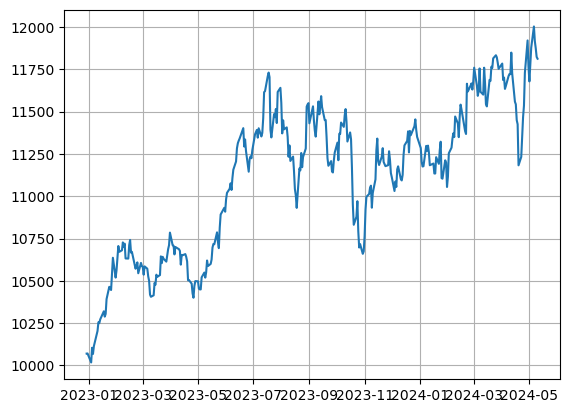

In [9]:
import matplotlib.pyplot as plt
from sqlalchemy import Select, Table, create_engine, MetaData
from sqlalchemy.orm import sessionmaker, declarative_base

portfolio1 = InitialisePortfolio("test1",10000,2000)

start_date = date(2022, 11, 28)  # Consistent use of date(YYYY, MM, DD)
end_date = date(2024, 9, 19)


test_buy = {
    date(2022, 12, 28): [("GOOG", 5), ("NVDA", 5), ("TSLA", 5), ("BABA", 5)],
    date(2023, 1, 3): [("GOOG", 3), ("NVDA", 4), ("TSLA", 1)],
    date(2023, 4, 6): [("BABA", 1)], 
    date(2023, 7, 6): [("BABA", 4)], 
    date(2023, 4, 5): [("NVDA", 7)], 
    date(2023, 7, 11): [("NVDA", 7),("TSLA", 4)],
    date(2024, 1, 3): [("BABA", 2), ("META", 1)]
}

test_sell = {
    date(2023, 1, 18): [("GOOG", 2), ("NVDA", 1), ("TSLA", 1)],
    date(2024, 2, 14): [("BABA", 7)],
    date(2024, 5, 13): [("TSLA", 8),("GOOG", 6),("NVDA", 16),("META", 6)]
    
}
df = Assess_days(portfolio1,start_date=start_date,end_date=end_date,test_buy=test_buy,test_sell=test_sell)

df['returns'] = df["Portfolio Value"].pct_change()
df2 = df[(df['Date'] > date(2022, 12, 28))&(df['Date'] < date(2024, 5, 13))]


plt.grid(True)
plt.plot(df2["Date"],df2["Portfolio Value"])

Text(0.05, 0.85, 'Average: 0.0005')

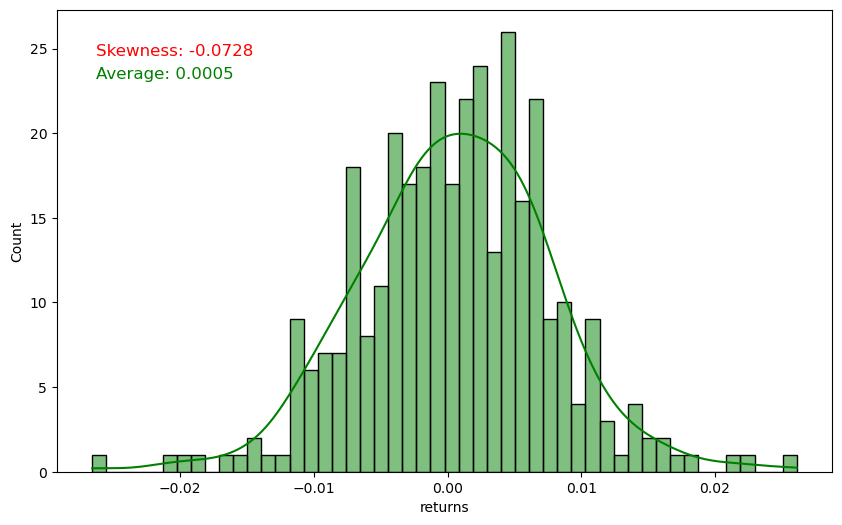

In [10]:
import seaborn as sns

# Plot the returns histogram using seaborn or matplotlib
plt.figure(figsize=(10, 6))
returns_skew = df2['returns'].skew()
returns_av = df2['returns'].mean()

sns.histplot(df2['returns'], bins=50, kde=True, color='green')
plt.text(0.05, 0.9, f'Skewness: {returns_skew:.4f}', transform=plt.gca().transAxes, fontsize=12, color='red')
plt.text(0.05, 0.85, f'Average: {returns_av:.4f}', transform=plt.gca().transAxes, fontsize=12, color='green')